## Glads testing

Exploring the best approach to convert GLADS alerts to cluster point types.

#### Possible approaches to check
* Convert the raster data into vectors and send them via folium (or whatever) to a cluster map
* Use the GLADS microservice to download points over a given area (geostore) and time and cluseter map those directly
* Use a server-side process to generate cluster maps and send them as a WMS tile layer

Open questions:
* Should this be for an area of interest, e.g. forest watcher areas, or over the whole layer?

In [1]:
import requests
import math
import pprint
import folium
import pandas as pd
import maya
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from folium.plugins import FastMarkerCluster
%matplotlib inline

In [2]:
## Testing based on extracting locations from tiles

tile_url='http://wri-tiles.s3.amazonaws.com/glad_prod/tiles/12/1376/2156.png'
im_arrays = misc.imread(requests.get(tile_url, stream=True).raw, mode='RGBA')

/Users/Ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


BAND 0: max=4, min=0


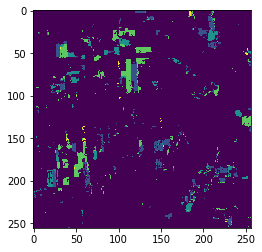

BAND 1: max=249, min=0


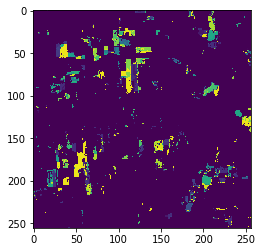

BAND 2: max=255, min=0


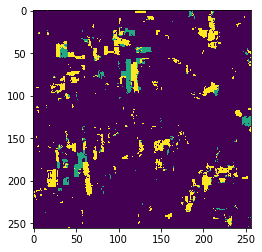

BAND 3: max=255, min=255


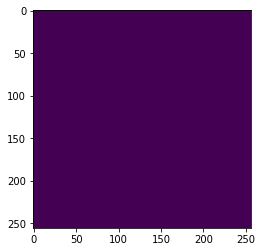

In [3]:
for band in range(0,4):
    print(f"BAND {band}: max={im_arrays[:,:,band].max()}, min={im_arrays[:,:,band].min()}")
    plt.imshow(im_arrays[:,:,band])
    plt.show()

In [4]:
def xyz_from_url(url):
    """Parse the url to  X, Y, Z"""
    z,x,y = tile_url.split('/')[-3:]
    y = y.split('.png')[0]
    z = int(z)
    y = int(y)
    x = int(x)
    return  x, y, z


def num2deg(xtile, ytile, zoom):
    """From a given Z,X,Y we can identify the upper left corner lat long"""
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return lat_deg, lon_deg

In [5]:
x,y,z = xyz_from_url(tile_url)
print(f'x={x}, y={y}, z={z}')

ul_corner_lat, ul_corner_lon = num2deg(x,y,z)
print(f"Upper Left-hand corner Latitude = {ul_corner_lat}, \nUpper Left-hand corner Longitude = {ul_corner_lon}")

x=1376, y=2156, z=12
Upper Left-hand corner Latitude = -9.449061826881424, 
Upper Left-hand corner Longitude = -59.0625


In [6]:
def gen_date_array(im_arrays, confident_values=True, verbose=False):
    """Recieve array (256,256,4) of R,G,B,A. Extract the date which has been encoded in the R +G
    bands. Date is days since 01-01-2015, where integer day is in the G-band, in base 256, once
    255 is reached, the corresponding array element in the R-band is incremented.
    Should return a numpy array of strings with either None, or a string date (YYYY-MM-DD).
    The dates are only returned if the blue-band has a value of 255, indicating a valid pixel.
    E.g. R=1, G=1 should equal 256 days since 01-01-2015
         R=0, G=10 should equal 10 days since 01-01-2015
    """
    base_date = maya.parse('01-01-2015')
    tmp = []
    red = im_arrays[:,:,0]
    green = im_arrays[:,:,1]
    
    if confident_values:
        blue = im_arrays[:,:,2]
        mask = blue != 255
        red = np.ma.masked_array(red, mask=mask)
        green = np.ma.masked_array(green, mask=mask)
    rg_flat = [pair for pair in zip(red.flatten(), green.flatten())]
    for r_band, g_band in rg_flat:
        if(np.sum([r_band, g_band]) > 0):
            days_to_add = (r_band * 255) + g_band
            final_date = base_date.add(days=int(days_to_add)).datetime().date()
            if verbose:
                print(f'r={r_band}, g={g_band}: {r_band * 255} + {g_band} = {days_to_add} , date = {final_date}')
            tmp.append(str(final_date))
        else:
            tmp.append(None)
    tmp = np.array(tmp).reshape((256,256))
    return tmp


def date_array_to_xydate_list(date_array):
    """Get a list of the x, y index for every element in the date array that is not None
    iterate over it and create a list of all the x,y, date-string values"""
    xydate = []
    idx = date_array.nonzero()
    xydate = [ [x,y,date_array[x,y]] for x,y in zip(idx[0], idx[1])]
    return xydate


def return_latlongdate(alerts_array, tilelon, tilelat,  tilezoom):
    """Convert a list of x,y, dates from date_array_to_xydate_list to a list of
    lat, lon, date (where lon, lat are the upper-left corner of the pixel).
    Pixel size in decimal degress is given by distance variable in this function.
    This works via trigonmetry!
    """
    distance = math.fabs((360/256)*(math.cos(tilelat)/(2**tilezoom)))
    return [[(tilelat - alert[0]*distance) , (alert[1]*distance + tilelon ), alert[2]] for alert in alerts_array]
    #return [num2deg(tilelon+alert[0], tilelat+alert[1], tilezoom) for alert in alerts_array]
    

        

In [7]:
# Get the tile metadata
x,y,z = xyz_from_url(tile_url)
ul_corner_lat, ul_corner_lon = num2deg(x,y,z)

# Scrape a list of x,y, dates from the tile (where alert confidence is high)
date_array = gen_date_array(im_arrays, confident_values=True)
good_list = date_array_to_xydate_list(date_array)

# convert the xydate to lon,lat,time
output_list = return_latlongdate(good_list, ul_corner_lon, ul_corner_lat, z)


print(num2deg(x,y,z))
print(f"{len(output_list):,g} glad alerts in tile")
pprint.pprint(output_list[0:10])

/Users/Ben/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: UserWarning: Warning: converting a masked element to nan.
  return umr_sum(a, axis, dtype, out, keepdims)


(-9.449061826881424, -59.0625)
4,111 glad alerts in tile
[[-9.449061826881424, -59.05700845553423, '2015-10-16'],
 [-9.449061826881424, -59.05666523400512, '2015-10-16'],
 [-9.449061826881424, -59.020626973448515, '2015-10-16'],
 [-9.449061826881424, -59.02028375191941, '2015-09-30'],
 [-9.449061826881424, -59.01994053039029, '2015-09-30'],
 [-9.449061826881424, -59.01959730886119, '2015-09-30'],
 [-9.449061826881424, -59.01925408733207, '2015-09-30'],
 [-9.449061826881424, -59.018910865802965, '2015-09-30'],
 [-9.449061826881424, -59.01856764427385, '2015-09-30'],
 [-9.449061826881424, -59.018224422744744, '2015-09-30']]


In [8]:
import folium.plugins.marker_cluster as marker_cluster

In [9]:
# with a date filter, convert the glad alerts points to markers

# Looks like lat/long need to be flipped too
data = [item[0:2] for item in output_list]

In [10]:
FastMarkerCluster?

Init signature: FastMarkerCluster(data, callback=None)
Docstring:     
Add marker clusters to a map using in-browser rendering.
Using FastMarkerCluster it is possible to render 000's of
points far quicker than the MarkerCluster class.

Be aware that the FastMarkerCluster class passes an empty
list to the parent class' __init__ method during initialisation.
This means that the add_child method is never called, and
no reference to any marker data are retained. Methods such
as get_bounds() are therefore not available when using it.

Parameters
----------
data: list
    List of list of shape [[], []]. Data points should be of
    the form [[lat, lng]].

callback: string, default None
    A string representation of a valid Javascript function
    that will be passed a lat, lon coordinate pair. See the
    FasterMarkerCluster for an example of a custom callback.
File:           ~/anaconda3/lib/python3.6/site-packages/folium/plugins/fast_marker_cluster.py
Type:           type


In [11]:
m = folium.Map(
    location=[-9.45, -59.01],
    zoom_start=9,
    max_zoom=20,
    tiles='Open Street Map',
    detect_retina=True,
)

FastMarkerCluster(data,).add_to(m)

m

## Geostore and Elastic Microservice method

Now let's try and do the same thing, only this time with a geostore area and the Elastic microservice (to simulate a forest watcher query).

If you wanted to get the number of alerts and geostore info you could use the glad-alerts endpoint like this:

In [12]:
geostore_id = '80687b7da8ce62a70e324e289358b339'  # A random user generated geostore shape (on the production server)
start_date = '2017-04-30'
end_date = '2018-02-01'
threshold = '30'
url = f"https://production-api.globalforestwatch.org/v1/glad-alerts?geostore={geostore_id}&period={start_date}%2C{end_date}&thresh={threshold}&_=1519213448472"
url

'https://production-api.globalforestwatch.org/v1/glad-alerts?geostore=80687b7da8ce62a70e324e289358b339&period=2017-04-30%2C2018-02-01&thresh=30&_=1519213448472'

In [13]:
r = requests.get(url)
if r.status_code == 200:
    alerts = r.json()
else:
    raise ValueError("Bad response from query")

In [14]:
r.json()

{'data': {'attributes': {'areaHa': 304036.55740211136,
   'downloadUrls': {'csv': '/download/db34c2d9-77b8-43ee-b101-f499e39d1597?sql=SELECT lat, long, confidence_text, country_iso, state_id, dist_id, year, julian_day FROM index_db34c2d977b843eeb101f499e39d1597 WHERE ((year = 2017 and julian_day >= 120) or (year = 2018 and julian_day <= 32))ORDER BY year, julian_day&format=csv&geostore=80687b7da8ce62a70e324e289358b339',
    'json': '/download/db34c2d9-77b8-43ee-b101-f499e39d1597?sql=SELECT lat, long, confidence_text, country_iso, state_id, dist_id, year, julian_day FROM index_db34c2d977b843eeb101f499e39d1597 WHERE ((year = 2017 and julian_day >= 120) or (year = 2018 and julian_day <= 32))ORDER BY year, julian_day&format=json&geostore=80687b7da8ce62a70e324e289358b339'},
   'value': 39114},
  'geostore': '80687b7da8ce62a70e324e289358b339',
  'id': 'db34c2d9-77b8-43ee-b101-f499e39d1597',
  'period': '2017-04-30,2018-02-01',
  'type': 'glad-alerts'}}

In [15]:
geostore_area = alerts.get('data').get('attributes').get('areaHa'), 
alert_count = alerts.get('data').get('attributes').get('value')
download_url = alerts.get('data').get('attributes').get('downloadUrls').get('csv')

In [16]:
print(f"Found {alert_count:,.0f} alerts over an {geostore_area[0]:,.0f}ha area.")

Found 39,114 alerts over an 304,037ha area.


But actually it is easier to use the `/download` endpoint directly, refrencing the glads table name like this:

In [17]:
api_url ="https://production-api.globalforestwatch.org/v1/" 
glads_dataset = "db34c2d9-77b8-43ee-b101-f499e39d1597"
geostore_id = "80687b7da8ce62a70e324e289358b339"
start_year = 2017
start_julday = 120
end_year = 2018
end_julday = 32

download_url = (f"{api_url}download/{glads_dataset}?sql=SELECT lat, long,"
f"confidence_text, country_iso, state_id, dist_id, year, julian_day FROM index_{glads_dataset} WHERE ((year = {start_year} and julian_day >= {start_julday}) or "
f"(year = {end_year} and julian_day <= {end_julday}))ORDER BY year, julian_day&format=csv&geostore={geostore_id}")

In [18]:
r2 = requests.get(download_url)
r2.status_code

200

Next, we parse the data into a table for ease of minipulation

In [19]:
downloaded_alerts = r2.text.split('\n')

downloaded_alerts[0:10]

['"dist_id","year","confidence_text","state_id","long","lat","country_iso","julian_day","_id"',
 '1414,2017,"confirmed",11,-52.277375,-20.906125,"BRA",123,"AWF8c70k8Jqrt1rpKKS4"',
 '1414,2017,"confirmed",11,-52.276625,-20.906125,"BRA",123,"AWF8c70k8Jqrt1rpKKS7"',
 '1414,2017,"confirmed",11,-52.276625,-20.909125,"BRA",123,"AWF8c70l8Jqrt1rpKKlv"',
 '1414,2017,"confirmed",11,-52.287625,-20.909375,"BRA",123,"AWF8c70l8Jqrt1rpKKnN"',
 '1414,2017,"confirmed",11,-52.287375,-20.909375,"BRA",123,"AWF8c70l8Jqrt1rpKKnO"',
 '1414,2017,"confirmed",11,-52.286375,-20.909375,"BRA",123,"AWF8c70l8Jqrt1rpKKnS"',
 '1414,2017,"confirmed",11,-52.271375,-20.909375,"BRA",123,"AWF8c70l8Jqrt1rpKKnt"',
 '1414,2017,"confirmed",11,-52.287625,-20.909625,"BRA",123,"AWF8c70l8Jqrt1rpKKo5"',
 '1414,2017,"confirmed",11,-52.287125,-20.909625,"BRA",123,"AWF8c70l8Jqrt1rpKKo7"']

In [20]:
formatted_data = []
for row in downloaded_alerts[:-1]:
    tmp = row.replace('"','').split(',')
    tmp_cleaned = []
    for item in tmp:
        try:
            tmp_cleaned.append(float(item))
        except:
            tmp_cleaned.append(item)
    formatted_data.append(tmp_cleaned)

In [21]:
table = pd.DataFrame(formatted_data[1:], columns=formatted_data[0])
table.head()

,dist_id,year,confidence_text,state_id,long,lat,country_iso,julian_day,_id
0,1414.0,2017.0,confirmed,11.0,-52.277375,-20.906125,BRA,123.0,AWF8c70k8Jqrt1rpKKS4
1,1414.0,2017.0,confirmed,11.0,-52.276625,-20.906125,BRA,123.0,AWF8c70k8Jqrt1rpKKS7
2,1414.0,2017.0,confirmed,11.0,-52.276625,-20.909125,BRA,123.0,AWF8c70l8Jqrt1rpKKlv
3,1414.0,2017.0,confirmed,11.0,-52.287625,-20.909375,BRA,123.0,AWF8c70l8Jqrt1rpKKnN
4,1414.0,2017.0,confirmed,11.0,-52.287375,-20.909375,BRA,123.0,AWF8c70l8Jqrt1rpKKnO


Next, all we need to do is extrat the lat, long and pass it to a cluster map function. 
For extra points we could also download the geojson geometry of the geostore and plot that too.

In [22]:
# finally just put the lat/long it in a simple list ready to cluster
tmp_data = []
for row in table[['lat','long']].values:
    tmp_data.append(list(row))

For completness lets also plot the geostore geometry too...

In [23]:
geostore_url = f'https://production-api.globalforestwatch.org/v1/geostore/{geostore_id}'

r3 = requests.get(geostore_url)
r3.status_code

200

In [24]:
geojson = r3.json().get('data').get('attributes').get('geojson')

In [25]:
m2 = folium.Map(
    location=[np.mean(table.lat.values), np.mean(table.long.values)],
    zoom_start=9,
    max_zoom=20,
    tiles='Open Street Map',
    detect_retina=True,
)

FastMarkerCluster(tmp_data).add_to(m2)

folium.GeoJson(
    geojson,
    name='Geostore'
).add_to(m2)

m2